## =============================================================================
## Password Strength Analysis and Prediction Pipeline using TF-IDF & Logistic Regression
## =============================================================================


### -----------------------------------------------------------------------------
### 1. Importing Necessary Libraries
### -----------------------------------------------------------------------------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import string
import warnings
from warnings import filterwarnings

### -----------------------------------------------------------------------------
### 2. Connecting to SQLite Database & Loading Data
### -----------------------------------------------------------------------------

In [3]:
# very first u have to create a SQL connection to our SQLite database
con = sqlite3.connect("password_data.sqlite")

In [4]:
# Read the entire Users table from the database
data = pd.read_sql_query("SELECT * FROM Users" , con)

In [5]:
# Check dataset dimensions and preview the first few records
data.shape
data.head(4)

,index,password,strength
0,0,zxe870819,1
1,1,xw46454nr23l,1
2,2,soporte13,1
3,3,accounts6000webhost.com,2


### -----------------------------------------------------------------------------
### 3. Basic Data Cleaning
### -----------------------------------------------------------------------------

In [6]:
# Display the column names
data.columns

Index(['index', 'password', 'strength'], dtype='object')

In [7]:
# Remove irrelevant features (drop the "index" column)
data.drop(["index"] , axis=1 , inplace=True)
data.head(4)

,password,strength
0,zxe870819,1
1,xw46454nr23l,1
2,soporte13,1
3,accounts6000webhost.com,2


In [8]:
# Check for duplicate rows and missing values
data.duplicated().sum()
data.isnull().any()
data.isnull().any().sum() 

np.int64(0)

In [9]:
# Display data types of each feature
data.dtypes

password    object
strength     int64
dtype: object

In [10]:
# Examine the "strength" column and its unique values
data["strength"].unique()

array([1, 2, 0])

### -----------------------------------------------------------------------------
### 4. Semantic Analysis of the 'password' Feature
### -----------------------------------------------------------------------------

In [11]:
# Preview the "password" column
data["password"][0]
type(data["password"][0])

str

In [12]:
#Check for passwords that are purely numeric
data["password"].str.isnumeric()
data[data["password"].str.isnumeric()].shape

(26, 2)

In [13]:
#Check for passwords that are purely uppercase
data[data["password"].str.isupper()].shape

(1506, 2)

In [14]:
#Check for passwords that are purely alphabetic
data[data["password"].str.isalpha()].shape

(50, 2)

In [15]:
#Check for passwords that are alphanumeric
data[data["password"].str.isalnum()].shape

(97203, 2)

In [16]:
#Check for passwords that are title-case
data[data["password"].str.istitle()].shape

(932, 2)

In [17]:
# Check for passwords that contain special characters
# Define a function to detect special characters using string.punctuation
def find_semantics(row):
    for char in row:
        if char in string.punctuation:
            return 1
        else:
            pass

In [18]:
# Apply function and count rows with special characters
data[data["password"].apply(find_semantics)==1].shape

(2663, 2)

### -----------------------------------------------------------------------------
### 5. Feature Engineering on the 'password' Feature
### -----------------------------------------------------------------------------

In [19]:
# Calculate length of every password
data["length"] = data["password"].str.len() 

In [20]:
password = "Shan99"
[char for char in password if char.islower()]
len([char for char in password if char.islower()])/len(password)

0.5

In [21]:
# Define functions to calculate frequency of different character types
def freq_lowercase(row):
    return len([char for char in row if char.islower()])/len(row)

In [22]:
def freq_uppercase(row):
    return len([char for char in row if char.isupper()])/len(row)

In [23]:
def freq_numerical_case(row):
    return len([char for char in row if char.isdigit()])/len(row)

In [24]:
# Apply the functions to create new features; round values to 3 decimals
data["lowercase_freq"] = np.round(data["password"].apply(freq_lowercase) , 3)

data["uppercase_freq"] = np.round(data["password"].apply(freq_uppercase) , 3)

data["digit_freq"] = np.round(data["password"].apply(freq_numerical_case) , 3)

In [25]:
# Frequency of Special Characters
def freq_special_case(row):
    special_chars = []
    for char in row:
        if not char.isalpha() and not char.isdigit():
            special_chars.append(char)
    return len(special_chars)

In [26]:
data["special_char_freq"] = np.round(data["password"].apply(freq_special_case) , 3) 
# Normalize the special character frequency by password length
data["special_char_freq"] = data["special_char_freq"]/data["length"] 

In [27]:
data.head(5)

,password,strength,length,lowercase_freq,uppercase_freq,digit_freq,special_char_freq
0,zxe870819,1,9,0.333,0.0,0.667,0.000000
1,xw46454nr23l,1,12,0.417,0.0,0.583,0.000000
2,soporte13,1,9,0.778,0.0,0.222,0.000000
3,accounts6000webhost.com,2,23,0.783,0.0,0.174,0.043478
4,c443balg,1,8,0.625,0.0,0.375,0.000000


### -----------------------------------------------------------------------------
### 6. Descriptive Statistics & Visualization
### -----------------------------------------------------------------------------

In [28]:
# Display aggregated statistics for length and strength
data[['length' , 'strength']].groupby(['strength']).agg(["min", "max" , "mean" , "median"])

length                       
            min  max       mean median
strength                              
0             1    7   6.550947    7.0
1             8   13   9.611074    9.0
2            14  220  15.953421   16.0

In [29]:
# Iterate through key features and display grouped statistics
cols = ['length', 'lowercase_freq', 'uppercase_freq',
       'digit_freq', 'special_char_freq']

for col in cols:
    print(col)
    print(data[[col , 'strength']].groupby(['strength']).agg(["min", "max" , "mean" , "median"]))
    print('\n')

length
         length                       
            min  max       mean median
strength                              
0             1    7   6.550947    7.0
1             8   13   9.611074    9.0
2            14  220  15.953421   16.0


lowercase_freq
         lowercase_freq                        
                    min    max      mean median
strength                                       
0                   0.0  1.000  0.708050  0.714
1                   0.0  0.923  0.630067  0.667
2                   0.0  0.917  0.424679  0.400


uppercase_freq
         uppercase_freq                        
                    min    max      mean median
strength                                       
0                   0.0  1.000  0.012872  0.000
1                   0.0  0.923  0.007915  0.000
2                   0.0  0.889  0.367633  0.429


digit_freq
         digit_freq                        
                min    max      mean median
strength                                   
0   

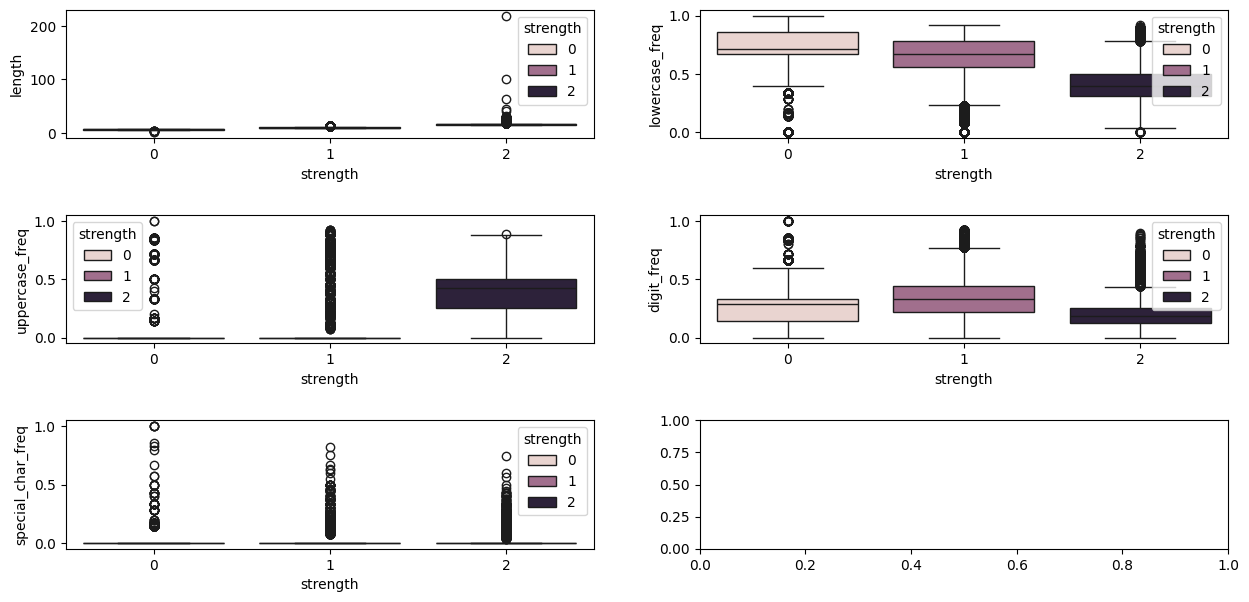

In [30]:
# Visualize using boxplots to summarize distributions
fig , ((ax1 , ax2) , (ax3 , ax4) , (ax5,ax6)) = plt.subplots(3 , 2 , figsize=(15,7))

sns.boxplot(x="strength" , y='length' , hue="strength" , ax=ax1 , data=data)
sns.boxplot(x="strength" , y='lowercase_freq' , hue="strength" , ax=ax2, data=data)
sns.boxplot(x="strength" , y='uppercase_freq' , hue="strength" , ax=ax3, data=data)
sns.boxplot(x="strength" , y='digit_freq' , hue="strength" , ax=ax4, data=data)
sns.boxplot(x="strength" , y='special_char_freq' , hue="strength" , ax=ax5, data=data)

plt.subplots_adjust(hspace=0.6)

### -----------------------------------------------------------------------------
### 7. Feature Importance using Distribution & Violin Plots
### -----------------------------------------------------------------------------

In [31]:
def get_dist(data , feature):
    
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
      # Left subplot: Violin plot by strength
    sns.violinplot(x='strength' , y=feature , data=data )
    
    # Right subplot: Distribution plots for each strength class
    plt.subplot(1, 2, 2)
    sns.histplot(data[data['strength'] == 0][feature], color="red", label="0", kde=True, stat="density", element="step")
    sns.histplot(data[data['strength'] == 1][feature], color="blue", label="1", kde=True, stat="density", element="step")
    sns.histplot(data[data['strength'] == 2][feature], color="orange", label="2", kde=True, stat="density", element="step")
    plt.legend()
    plt.show()

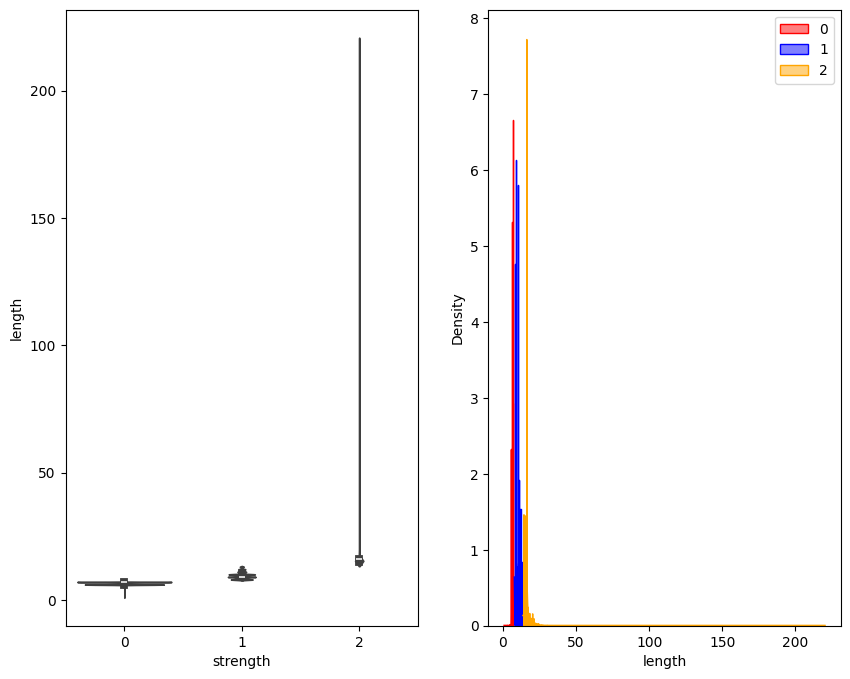

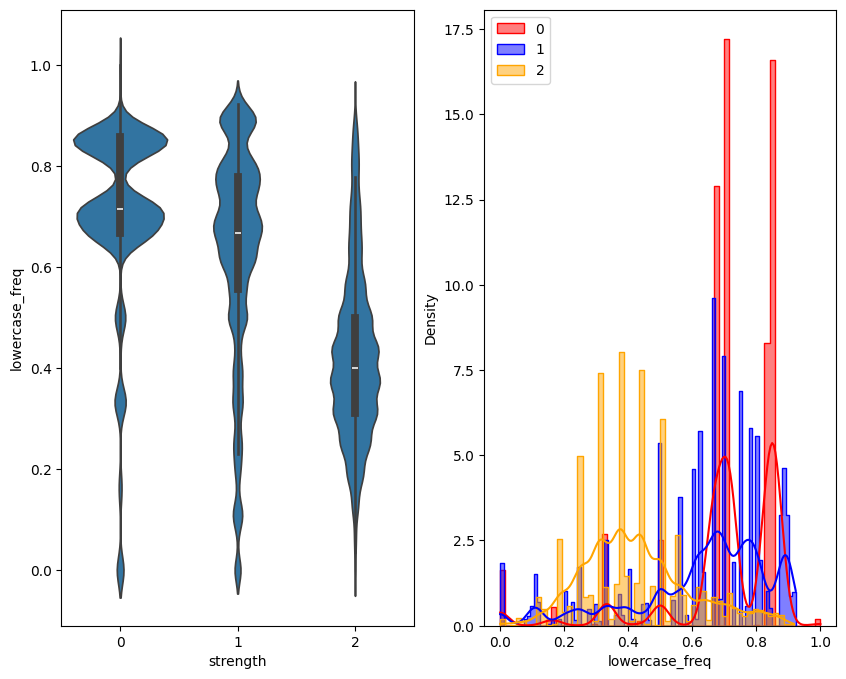

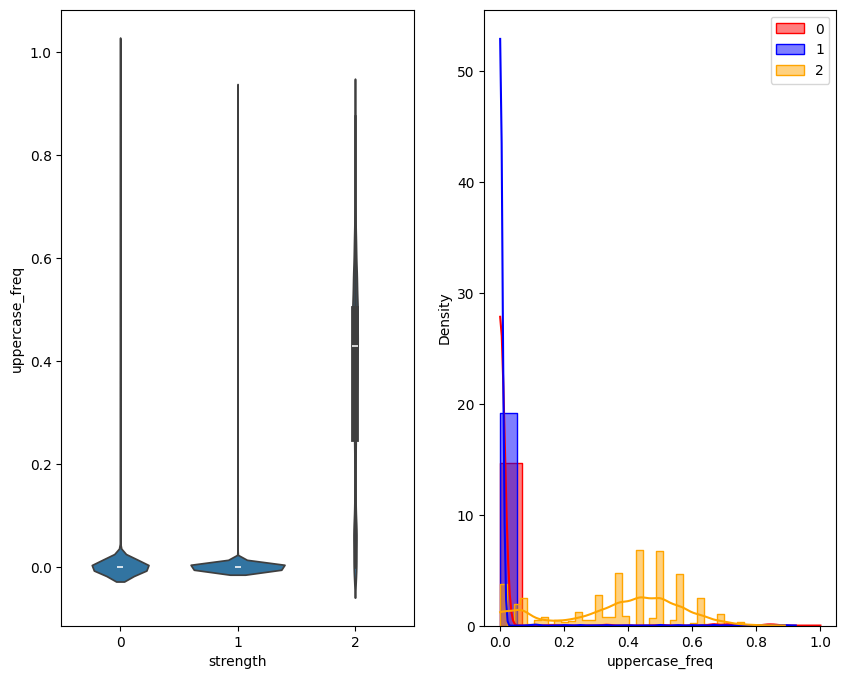

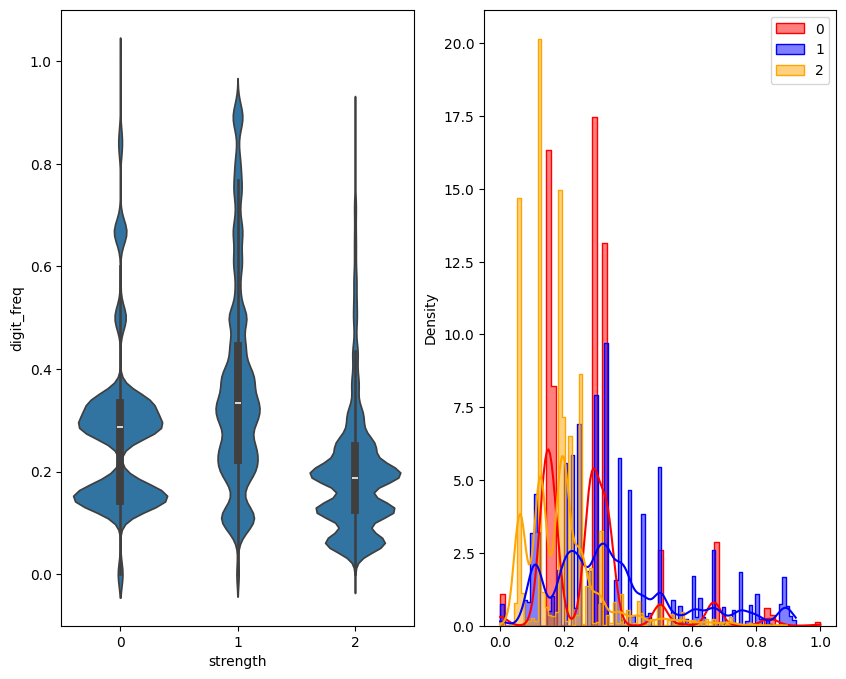

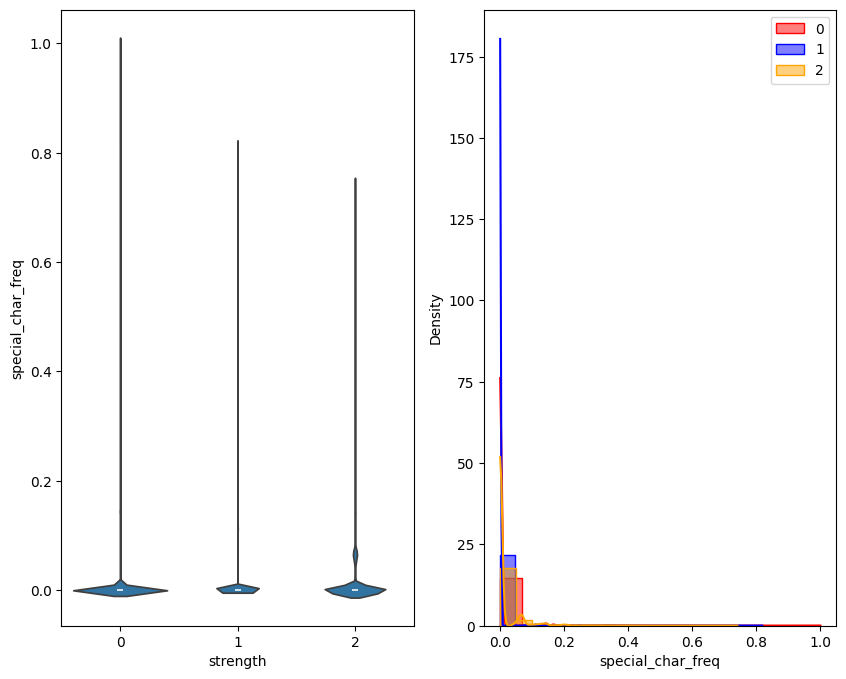

In [32]:
filterwarnings("ignore")
# Plot distributions for key features
get_dist(data, "length")
get_dist(data, "lowercase_freq")
get_dist(data, "uppercase_freq")
get_dist(data, "digit_freq")
get_dist(data, "special_char_freq")

### -----------------------------------------------------------------------------
### 8. Applying TF-IDF on Password Data
### -----------------------------------------------------------------------------

In [33]:
# shuffling randomly for robustness of ML moodel 
dataframe = data.sample(frac=1) 
# Convert the "password" column to a list for TF-IDF vectorization
x = list(dataframe["password"])

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer="char")
X = vectorizer.fit_transform(x)
X.shape

(100000, 99)

In [35]:
# Display sample TF-IDF vector and feature names
X.toarray()[0] 
vectorizer.get_feature_names_out()

array(['\x04', '\x06', '\x08', '\x0e', '\x10', '\x11', '\x17', ' ', '!',
       '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/', '0', '1',
       '2', '3', '4', '5', '6', '7', '8', '9', ';', '<', '=', '>', '?',
       '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's',
       't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¨',
       '°', '±', '³', '´', 'µ', '·', 'ß', 'à', 'á', 'ä', 'æ', 'ç', 'é',
       'ê', 'í', 'ñ', 'ó', 'õ', 'ö', '÷', 'ú', 'ü', 'ý', 'þ', '›'],
      dtype=object)

In [36]:
# Convert the TF-IDF matrix to a DataFrame for further processing
df2 = pd.DataFrame(X.toarray() , columns=vectorizer.get_feature_names_out())

### -----------------------------------------------------------------------------
### 9. Building the Machine Learning Model
### -----------------------------------------------------------------------------

In [37]:
# Append additional features (length and lowercase frequency) to the TF-IDF DataFrame
df2["length"] = dataframe['length']
df2["lowercase_freq"] = dataframe['lowercase_freq']

In [38]:
# Define the target variable: password strength
y = dataframe["strength"]

In [39]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=0.20)
X_train.shape
y_train.shape

(80000,)

In [40]:
# Train a Logistic Regression model for multi-class classification
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class="multinomial")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 
y_pred

array([1, 1, 1, ..., 2, 1, 1], shape=(20000,))

In [41]:
# Check distribution of predictions
from collections import Counter
Counter(y_pred)

Counter({np.int64(1): 16929, np.int64(2): 1871, np.int64(0): 1200})

### -----------------------------------------------------------------------------
### 10. Predicting Password Strength from User Input
### -----------------------------------------------------------------------------

In [42]:
# Since the Logistic Regression model 'clf' is trained on 101 features (99 from TF-IDF and 2 extra features),
# we need to transform any user input into the same shape.
# The following function automates that process:
def predict():
    password = input("Enter a password : ")
    sample_array = np.array([password])
    sample_matrix = vectorizer.transform(sample_array)
    
    length_pass = len(password)
    length_normalised_lowercase = len([char for char in password if char.islower()])/len(password)
    
    new_matrix2 = np.append(sample_matrix.toarray() , (length_pass , length_normalised_lowercase)).reshape(1,101)
    result = clf.predict(new_matrix2)
    
    if result == 0 :
        return "Password is weak"
    elif result == 1 :
        return "Password is normal"
    else:
        return "password is strong"

### -----------------------------------------------------------------------------
### 11. Model Evaluation
### -----------------------------------------------------------------------------

In [43]:
from sklearn.metrics import confusion_matrix ,  accuracy_score , classification_report

In [44]:
# Calculate and display model accuracy
accuracy_score(y_test , y_pred)

0.8041

In [45]:
# Display confusion matrix and classification report
confusion_matrix(y_test , y_pred)
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.56      0.24      0.34      2794
           1       0.82      0.94      0.88     14738
           2       0.80      0.61      0.69      2468

    accuracy                           0.80     20000
   macro avg       0.73      0.60      0.64     20000
weighted avg       0.78      0.80      0.78     20000



In [46]:
# Check model performance again on test data
accuracy_score(y_test, clf.predict(X_test)) 

0.8041

In [ ]:
# Check your password
predict()